# 19. 텍스트 요약(Text Summarization)

## 2) 문장 임베딩 기반 텍스트 랭크(TextRank Based on Sentence Embedding)

이번 실습에서는 텍스트랭크(TextRank) 알고리즘으로 사용하여 또 다른 텍스트 요약 방법인 추출적 요약을 진행해보겠습니다.

### 1. 텍스트랭크(TextRank)

텍스트랭크 알고리즘은 페이지랭크를 기반으로 한 텍스트 요약 알고리즘입니다. 텍스트랭크에서 그래프의 노드들은 문장들이며, 각 간선의 가중치는 문장들 간의 유사도를 의미합니다.

### 2. 사전 훈련된 임베딩(Pre-trained Embedding)

In [3]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

In [5]:
glove_dict = dict()
f = open('preTrained/glove.6B.100d.txt', encoding="utf8") # 100차원의 GloVe 벡터를 사용

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    glove_dict[word] = word_vector_arr
f.close()

### 3. 문장 임베딩(Sentence Embedding)

문장 벡터를 얻는 가장 간단한 방법은 문장에 존재하는 단어 벡터들의 평균을 구하는 것입니다.

In [6]:
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)

아래 함수는 문장의 각 단어를 사전 훈련된 GloVe 벡터로 변환하면서, OOV 문제가 발생할 경우에는 해당 단어를 영벡터로 변환합니다. 그리고 이렇게 모인 단어 벡터들의 평균을 구하여 반환합니다.

In [7]:
# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
    return sum([glove_dict.get(word, zero_vector) for word in sentence])/len(sentence)

### 4. 텍스트 랭크를 이용한 텍스트 요약

In [8]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [9]:
stop_words = stopwords.words('english')

In [11]:
# urlretrieve("https://raw.githubusercontent.com/prateekjoshi565/textrank_text_summarization/master/tennis_articles_v4.csv", 
#             filename="datasets/tennis_articles_v4.csv")
data = pd.read_csv("datasets/tennis_articles_v4.csv")
data.head()

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


article_text열만 사용하기로 하고, 해당 기사를 문장 토큰화한 결과를 저장한 sentences라는 열을 새로 만듭니다.

In [12]:
data = data[['article_text']]
data['sentences'] = data['article_text'].apply(sent_tokenize)
data

,article_text,sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...
1,"BASEL, Switzerland (AP), Roger Federer advance...","[BASEL, Switzerland (AP), Roger Federer advanc..."
2,Roger Federer has revealed that organisers of ...,[Roger Federer has revealed that organisers of...
3,Kei Nishikori will try to end his long losing ...,[Kei Nishikori will try to end his long losing...
4,"Federer, 37, first broke through on tour over ...","[Federer, 37, first broke through on tour over..."
5,Nadal has not played tennis since he was force...,[Nadal has not played tennis since he was forc...
6,"Tennis giveth, and tennis taketh away. The end...","[Tennis giveth, and tennis taketh away., The e..."
7,Federer won the Swiss Indoors last week by bea...,[Federer won the Swiss Indoors last week by be...


토큰화와 전처리를 위한 함수들을 정의합니다.

In [13]:
# 토큰화 함수
def tokenization(sentences):
    return [word_tokenize(sentence) for sentence in sentences]

# 전처리 함수
def preprocess_sentence(sentence):
    # 영어를 제외한 숫자, 특수 문자 등은 전부 제거. 모든 알파벳은 소문자화
    sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]
    # 불용어가 아니면서 단어가 실제로 존재해야 한다.
    return [word for word in sentence if word not in stop_words and word]

# 위 전처리 함수를 모든 문장에 대해서 수행. 이 함수를 호출하면 모든 행에 대해서 수행.
def preprocess_sentences(sentences):
    return [preprocess_sentence(sentence) for sentence in sentences]

문장 토큰화를 진행한 'sentences'열에 대해서 단어 토큰화와 전처리를 적용한 'tokenized_sentences' 열을 새로 만듭니다.

In [14]:
data['tokenized_sentences'] = data['sentences'].apply(tokenization)
data['tokenized_sentences'] = data['tokenized_sentences'].apply(preprocess_sentences)
data

,article_text,sentences,tokenized_sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...,"[[maria, sharapova, basically, friends, tennis..."
1,"BASEL, Switzerland (AP), Roger Federer advance...","[BASEL, Switzerland (AP), Roger Federer advanc...","[[basel, switzerland, ap, roger, federer, adva..."
2,Roger Federer has revealed that organisers of ...,[Roger Federer has revealed that organisers of...,"[[roger, federer, revealed, organisers, relaun..."
3,Kei Nishikori will try to end his long losing ...,[Kei Nishikori will try to end his long losing...,"[[kei, nishikori, try, end, long, losing, stre..."
4,"Federer, 37, first broke through on tour over ...","[Federer, 37, first broke through on tour over...","[[federer, first, broke, tour, two, decades, a..."
5,Nadal has not played tennis since he was force...,[Nadal has not played tennis since he was forc...,"[[nadal, played, tennis, since, forced, retire..."
6,"Tennis giveth, and tennis taketh away. The end...","[Tennis giveth, and tennis taketh away., The e...","[[tennis, giveth, tennis, taketh, away], [end,..."
7,Federer won the Swiss Indoors last week by bea...,[Federer won the Swiss Indoors last week by be...,"[[federer, swiss, indoors, last, week, beating..."


단어 벡터의 평균을 구하는 함수를 정의합니다.

단, 문장 길이가 0일 경우에는 100차원의 영벡터를 리턴합니다. 현재 불용어를 제거하였기 때문에 문장의 모든 단어가 불용어인 경우에는 길이가 0인 문장이 생길 수 있기 때문입니다.

In [15]:
# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
    if len(sentence) != 0:
        return sum([glove_dict.get(word, zero_vector) for word in sentence])/len(sentence)
    else:
        return zero_vector

이를 모든 행에 대해서 수행하기 위해서 모든 문장에 대해서 수행하는 함수를 정의합니다.

In [16]:
# 각 문장에 대해서 문장 벡터를 반환
def sentences_to_vectors(sentences):
    return [calculate_sentence_vector(sentence) 
              for sentence in sentences]

모든 문장에 대해서 문장 벡터를 만듭니다.

In [17]:
data['SentenceEmbedding'] = data['tokenized_sentences'].apply(sentences_to_vectors)
data[['SentenceEmbedding']]

,SentenceEmbedding
0,"[[0.051488996, 0.1105585, 0.6950863, 0.1891917..."
1,"[[0.10566062456928194, -0.10534465219825506, 0..."
2,"[[-0.022272188, -0.0474477, 0.14933074, -0.086..."
3,"[[0.045201838, -0.064647146, 0.5035717, -0.160..."
4,"[[0.21536233, 0.180915, 0.25600883, 0.06924241..."
5,"[[0.04484453, -0.0074302587, 0.33349112, -0.07..."
6,"[[-0.115338005, -0.0062844106, 0.595185, -0.16..."
7,"[[0.0740439, 0.059211146, 0.49143884, 0.216771..."


문장 벡터들 간의 코사인 유사도를 구한 유사도 행렬을 만듭니다. 

이 유사도 행렬의 크기는 (문장 개수 × 문장 개수)입니다.

In [18]:
def similarity_matrix(sentence_embedding):
    sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])
    for i in range(len(sentence_embedding)):
        for j in range(len(sentence_embedding)):
            sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                          sentence_embedding[j].reshape(1, embedding_dim))[0,0]
    return sim_mat

이 결과를 저장한 'SimMatrix'열을 만듭니다.

In [19]:
data['SimMatrix'] = data['SentenceEmbedding'].apply(similarity_matrix)
data['SimMatrix']

0    [[1.0, 0.6477208137512207, 0.5915699601173401,...
1    [[0.9999999999999999, 0.8745531210608368, 0.80...
2    [[1.0, 0.9130854606628418, 0.8992924690246582,...
3    [[0.9999999403953552, 0.776917930529404, 0.840...
4    [[1.0, 0.8306209732530097, 0.9082390069961548,...
5    [[1.0, 0.8843014240264893, 0.8540289072721127,...
6    [[0.9999999403953552, 0.473054975271225, 0.450...
7    [[0.9999999403953552, 0.7634095600081803, 0.78...
Name: SimMatrix, dtype: object

두번째 샘플을 기준으로 지금까지 만든 열들의 크기를 확인해봅시다.

In [20]:
print('두번째 샘플의 문장 개수 :', len(data['tokenized_sentences'][1]))
print('두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) :', np.shape(data['SentenceEmbedding'][1]))
print('두번째 샘플의 유사도 행렬의 크기(shape) :', data['SimMatrix'][1].shape)

두번째 샘플의 문장 개수 : 12
두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) : (12, 100)
두번째 샘플의 유사도 행렬의 크기(shape) : (12, 12)


주어진 유사도 행렬로부터 그래프를 그려봅시다.

In [21]:
def draw_graphs(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
    plt.show()

두번째 샘플의 유사도 행렬로부터 그린 그래프는 다음과 같습니다.

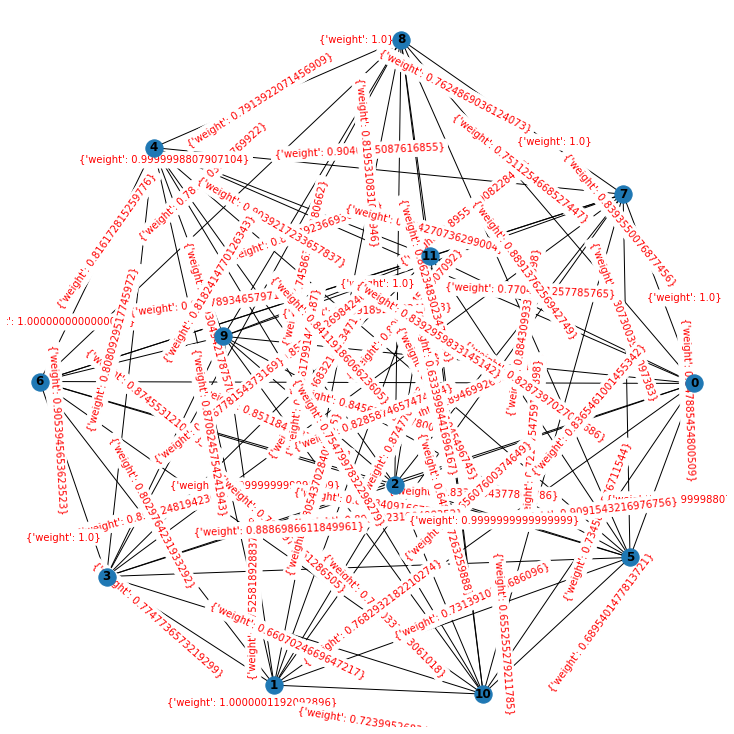

In [22]:
draw_graphs(data['SimMatrix'][1])

그래프를 페이지랭크 알고리즘의 입력으로 사용하여 각 문장의 점수를 구합니다.

In [23]:
def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores

In [24]:
data['score'] = data['SimMatrix'].apply(calculate_score)
data[['SimMatrix', 'score']]

,SimMatrix,score
0,"[[1.0, 0.6477208137512207, 0.5915699601173401,...","{0: 0.054921592732108095, 1: 0.062865200535766..."
1,"[[0.9999999999999999, 0.8745531210608368, 0.80...","{0: 0.08315094488396522, 1: 0.0849861141998688..."
2,"[[1.0, 0.9130854606628418, 0.8992924690246582,...","{0: 0.061484409245011376, 1: 0.062248643312614..."
3,"[[0.9999999403953552, 0.776917930529404, 0.840...","{0: 0.08164728031659976, 1: 0.0727647943602178..."
4,"[[1.0, 0.8306209732530097, 0.9082390069961548,...","{0: 0.05568689947651565, 1: 0.0509923187928486..."
5,"[[1.0, 0.8843014240264893, 0.8540289072721127,...","{0: 0.08288694411607728, 1: 0.0840376021962047..."
6,"[[0.9999999403953552, 0.473054975271225, 0.450...","{0: 0.07336251710605873, 1: 0.1050889020506283..."
7,"[[0.9999999403953552, 0.7634095600081803, 0.78...","{0: 0.04321039324172964, 1: 0.0473333990446681..."


두번째 샘플의 각 문장의 점수를 출력해봅시다. 총 12개 문장에 대해서 점수가 기록되어져 있습니다.

In [25]:
data['score'][1]

{0: 0.08315094488396522,
 1: 0.08498611419986883,
 2: 0.08555019800894194,
 3: 0.08383717313818075,
 4: 0.08137940363815209,
 5: 0.0843928508251235,
 6: 0.08507725751543575,
 7: 0.08092839165681333,
 8: 0.07454045927322153,
 9: 0.08535836586786766,
 10: 0.08498242505945912,
 11: 0.08581641593297012}

이제 이 점수가 가장 높은 문장들을 상위 n개 선택하여 이 문서의 요약문으로 삼을 것입니다. 점수가 가장 높은 상위 3개의 문장을 선택하는 함수를 만듭니다. 점수에 따라서 정렬 후에 상위 3개 문장만을 반환합니다.

In [26]:
def ranked_sentences(sentences, scores, n=3):
    top_scores = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    top_n_sentences = [sentence for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)

이 함수를 사용하여 'summary'라는 열을 만듭니다.

In [27]:
data['summary'] = data.apply(lambda x: ranked_sentences(x.sentences, x.score), axis=1)

문서에 대해서 원문과 요약문을 출력해볼까요?

In [28]:
for i in range(0, 2):
    print(i+1,'번 문서')
    print('원문 :',data.loc[i].article_text)
    print('')
    print('요약 :',data.loc[i].summary)
    print('')

1 번 문서
원문 : Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. I'm a pretty competitive girl. I say my hellos, but I'm not sending any players flowers as well. Uhm, I'm not really friendly or close to many players. I have not a lot of friends away from the courts.' When she said she is not really close to a lot of players, is that something strategic that she is doing? Is it different on the men's tour than the women's tour? 'No, not at all. I think just because you're i